# Code to identify mis-classified points and explore their features

July 21, 2020


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import subprocess as sp
import pickle
import ipywidgets as widgets
import time


In [2]:
from sklearn.metrics import roc_curve

In [3]:
%matplotlib widget

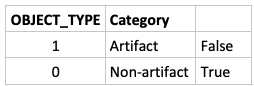

## Read test data and predictions

In [4]:
main_dir='/global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/results_data/results/final_summary_data_folder/'

In [5]:
f1=main_dir+'sample_test_data/temp_bigger_data/input_labels_y.txt'
f2=main_dir+'results_inference/y_large_pred.txt'

In [6]:
df=pd.DataFrame()
df['label']=np.loadtxt(f1,dtype=np.int16)
df['pred']=np.loadtxt(f2,dtype=np.float32)

print(df.shape)
df.head()


(5000, 2)


,label,pred
0,1,0.999773
1,0,0.000031
2,1,0.999562
3,1,0.995830
4,1,0.999947


## Histograms

In [7]:
df.plot(kind='hist',y=['label','pred'],subplots=True,grid=True,bins=12)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

In [8]:
### Prediction histograms
#### Comparing predction

plt.figure()
column='pred'
# Predictions at points where label is 1
sig_preds=df[df.label==1][column].values
# Predictions at points where label is 0
bkg_preds=df[df.label==0][column].values
plt.hist([sig_preds,bkg_preds],bins=20,alpha=0.5,label=[column+':Artifact=1',column+':non-artifacts=0'])
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot roc curve

####The ROC curve flip argument

Since True=1 in keras, but Non-Artifact is defined as 0 in the paper, 
Tp <-> Tn and Fn <-> Fp

Actual roc curve is x=mdr, y=fpr


mdr=Fn/(Tp+Fn) -> Fp/(Tn+Fp) = fpr \

fpr=Fp/(Tn+Fp) -> Fn/(Tp+Fn) = mdr = fnr = 1-tpr


Hence we get an mdr <-> fpr flip


In [112]:
def f_roc(df,col,label,fig_type='mdr'):
    '''
    Function to plot the roc curve
    '''
    fpr,tpr,threshold=roc_curve(df.label,df[col],pos_label=None)
    
    if fig_type=='mdr':
#         x,y=1-tpr,fpr 
        x,y=fpr,(1-tpr)     # The roc curve flip: mdr-> fpr; fpr-> (1-tpr)
        plt.plot(x, y,linestyle='',label=label,markersize=4,marker='*')
        # ### Reference points in mdr plot in paper
        
    
        rf_2015_lst=[(0.03,0.038),(0.04,0.024),(0.05,0.016)]
        for count,a in enumerate(rf_2015_lst):
            if count==0:
                plt.plot(a[0],a[1],marker='s',markersize=8,color='k',label='RF_2015')
            else: 
                plt.plot(a[0],a[1],marker='s',markersize=8,color='k')

        plt.xlabel('MDR')
        plt.ylabel('FPR')
        plt.xlim(0,0.1)
        plt.ylim(0,0.05)
        
    if fig_type=='tpr':
        x,y=(1-tpr),(1-fpr)     # The roc curve flip: fpr-> (1-tpr); tpr-> (1-fpr)
        plt.plot(x, y,linestyle='',label=label,markersize=4,marker='*')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    
    plt.legend()
    

In [120]:
plt.figure()
f_roc(df,'pred','pred',fig_type='mdr')
plt.title('MDR roc curve')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'MDR roc curve')

In [121]:

plt.figure()
f_roc(df,'pred','pred',fig_type='tpr')
# plt.xscale('log')
plt.xlim(0,1)
plt.title('TPR roc curve')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'TPR roc curve')

### Threshold prediction

In [132]:
fpr,tpr,threshold=roc_curve(df.label,df['pred'],pos_label=None)

cols=['threshold','fpr','tpr','mdr']
df_roc=pd.DataFrame(columns=cols)
# for i,j in zip(['threshold','fpr','tpr','mdr'],[threshold,fpr,tpr,1-tpr]):  ### the method for normal signal-background
for i,j in zip(['threshold','fpr','tpr','mdr'],[threshold,1-tpr,1-fpr,fpr]): # the method for our case: Artifact is 0
    df_roc[i]=j


In [133]:
df_roc

,threshold,fpr,tpr,mdr
0,2.000000e+00,1.000000,1.000000,0.000000
1,1.000000e+00,0.997159,1.000000,0.000000
2,9.999999e-01,0.994318,1.000000,0.000000
3,9.999999e-01,0.990260,1.000000,0.000000
4,9.999998e-01,0.987825,1.000000,0.000000
...,...,...,...,...
491,7.033348e-06,0.000000,0.013407,0.986593
492,6.973743e-06,0.000000,0.012618,0.987382
493,5.960464e-06,0.000000,0.009464,0.990536
494,5.811453e-06,0.000000,0.008675,0.991325


In [134]:
df_roc[1:].plot(kind='line',y=['threshold','mdr','fpr','tpr'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [126]:
df_roc[1:].plot(kind='line',x='threshold',y=['fpr','tpr','mdr'],style='*')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='threshold'>

In [136]:
def f_get_threshold(df_roc,value,metric='fpr'):
    
    assert metric in ['fpr','tpr','mdr'], "metric not any of fpr,tpr, mdr"

    if metric=='fpr':
        df=df_roc[df_roc[metric]<value].sort_values(by=metric,ascending=False)
        print("For %s < %s, threshold < %s "%(metric,value,df.loc[df[metric].idxmax()].threshold))

    if metric=='mdr':
        df=df_roc[df_roc[metric]<value].sort_values(by=metric,ascending=False)
        print("For %s < %s, threshold > %s "%(metric,value,df.loc[df[metric].idxmax()].threshold))

    if metric=='tpr':
        df=df_roc[df_roc[metric]>value].sort_values(by=metric,ascending=True)
        print("For %s > %s, threshold > %s "%(metric,value,df.loc[df[metric].idxmin()].threshold))

#     print(df.loc[df[metric].idxmax()].threshold)

    display(df)
#     return df

print("Threshold definition: Value > threshold is defined as False (Non-artifact)")
f_get_threshold(df_roc,0.01,'fpr')
f_get_threshold(df_roc,0.005,'mdr')
f_get_threshold(df_roc,0.99,'tpr')

Threshold definition: Value > threshold is defined as False (Non-artifact)
For fpr < 0.01, threshold < 0.3719293475151062 


,threshold,fpr,tpr,mdr
306,3.719293e-01,0.009334,0.987776,0.012224
307,3.638829e-01,0.009334,0.987382,0.012618
308,3.612459e-01,0.008929,0.987382,0.012618
309,3.440493e-01,0.008929,0.986987,0.013013
310,3.420588e-01,0.008523,0.986987,0.013013
...,...,...,...,...
395,7.647276e-05,0.000000,0.234621,0.765379
396,7.611513e-05,0.000000,0.233833,0.766167
397,7.528067e-05,0.000000,0.231467,0.768533
398,7.495284e-05,0.000000,0.230678,0.769322


For mdr < 0.005, threshold > 0.7914935350418091 


,threshold,fpr,tpr,mdr
280,0.791494,0.038961,0.995662,0.004338
279,0.810335,0.042614,0.995662,0.004338
278,0.811112,0.042614,0.996057,0.003943
277,0.811672,0.043425,0.996057,0.003943
276,0.811826,0.043425,0.996451,0.003549
...,...,...,...,...
100,0.999989,0.877841,1.000000,0.000000
101,0.999989,0.877029,1.000000,0.000000
102,0.999989,0.876218,1.000000,0.000000
103,0.999989,0.875000,1.000000,0.000000


For tpr > 0.99, threshold > 0.463934987783432 


,threshold,fpr,tpr,mdr
300,0.463935,0.012987,0.990931,0.009069
299,0.483647,0.014610,0.990931,0.009069
297,0.567416,0.017857,0.991719,0.008281
298,0.510624,0.014610,0.991719,0.008281
295,0.600669,0.019886,0.992114,0.007886
...,...,...,...,...
97,0.999989,0.881088,1.000000,0.000000
96,0.999989,0.882305,1.000000,0.000000
95,0.999990,0.884740,1.000000,0.000000
93,0.999990,0.886364,1.000000,0.000000


In [111]:
# f_get_threshold(df_roc,0.01,'fpr')
# f_get_threshold(df_roc,0.005,'mdr')
# f_get_threshold(df_roc,0.99,'tpr')